# Usage example: Metabric dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sksurv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored

import seaborn as sns
import torch
from torch import Tensor
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from preprocess_metabric import preprocess
import loss, VAE_surv
from VAE_surv import VAESurv

In [2]:
data_path = 'Data/METABRIC_RNA_Mutation.csv'
df_final_train, df_final_test, y_train, y_test, mask = preprocess(data_path)

/shared/crollo/VAE-Surv/preprocess_metabric.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(mapping)
/shared/crollo/VAE-Surv/preprocess_metabric.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cellularity'] = df['cellularity'].replace({'Low': 1, 'Moderate': 2, 'High': 3})
/shared/crollo/VAE-Surv/preprocess_metabric.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(co

# VAE-Surv

In [3]:
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(0)

In [7]:
import json
with open("config.json", "r") as file:
    config = json.load(file)
config["vae_feature_mask"] = mask  

if config["device"] == "cuda" and not torch.cuda.is_available():
    config["device"] = "cpu"

# Instantiate the model with the loaded configuration
vae_surv = VAESurv(**config)

In [8]:
X_train = torch.tensor(df_final_train.values, dtype=torch.float32)
X_test = torch.tensor(df_final_test.values, dtype=torch.float32)

In [9]:
# Train the model
vae_surv.fit(X_train, y_train, X_test, y_test)

VAE pretraining: 100%|███████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.56it/s]
Training: 0it [00:00, ?it/s]
Post training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.80it/s]


In [10]:
th_df = vae_surv.train_history_.get_df()

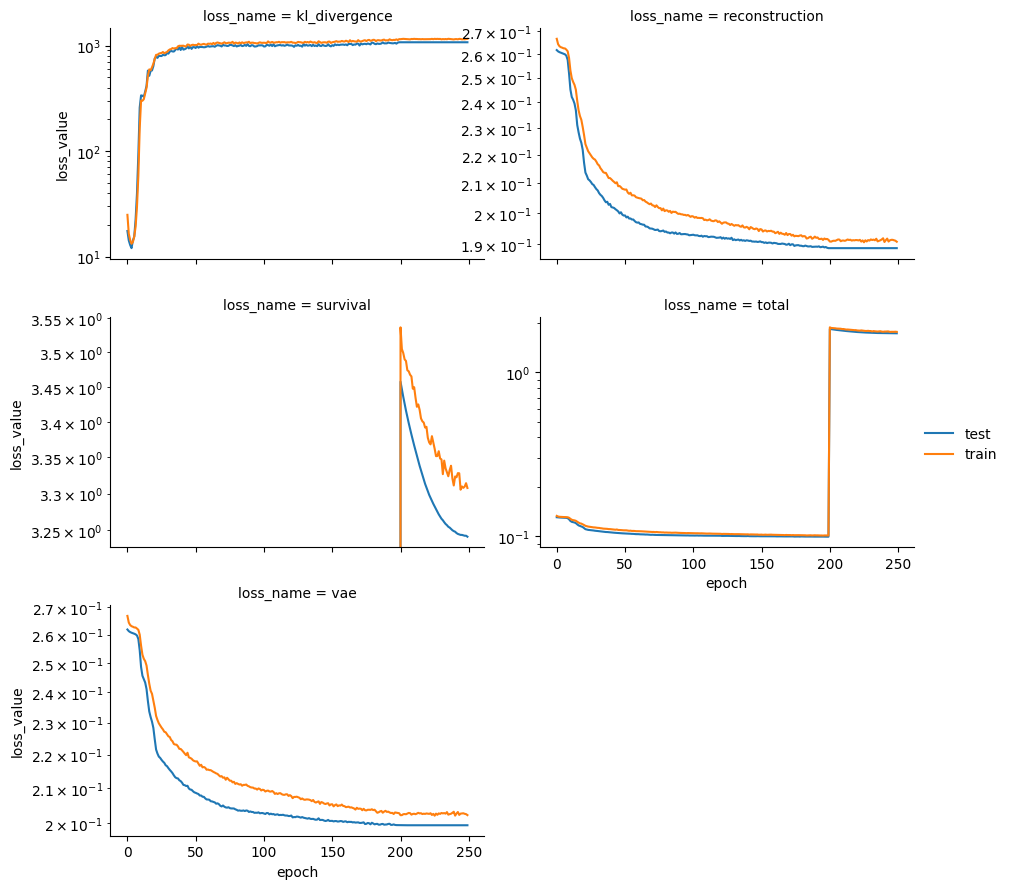

In [11]:
# Get the training history DataFrame
th_df = vae_surv.train_history_.get_df()

# Filter out losses you might not want to plot (e.g., c-index, kl_divergence)
loss_df = th_df.query('loss_name != "c-index" ')# and loss_name != "kl_divergence"')

# Optionally, group by epoch, dataset, and loss_name to average values (if needed)
loss_df = loss_df.groupby(['epoch', 'dataset', 'loss_name'], as_index=False).mean()

# Create a FacetGrid where each facet is one loss type.
g = sns.FacetGrid(loss_df, col="loss_name", col_wrap=2, sharey=False, height=3, aspect=1.5)

# Map a lineplot to each facet. 'hue' will differentiate between 'train' and 'test'
g.map_dataframe(sns.lineplot, x='epoch', y='loss_value', hue='dataset')

# Add a legend to one of the facets
g.add_legend()

# Optionally set the y-axis to a log scale for all facets
for ax in g.axes.flat:
    ax.set_yscale('log')

plt.show()

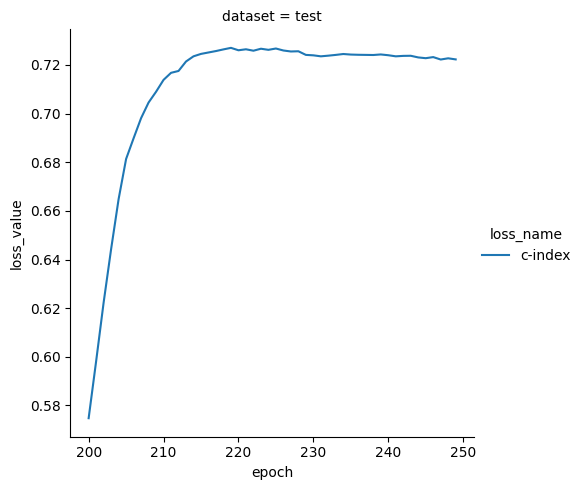

In [12]:
sns.relplot(th_df.query('loss_name == "c-index"'), x='epoch', y='loss_value', hue='loss_name', col='dataset', kind='line')

In [13]:
c_index_train = vae_surv.score(X_train, y_train)
print(f"C-index on Train set: {c_index_train:.4f}")
c_index_test = vae_surv.score(X_test, y_test)
print(f"C-index on Test set: {c_index_test:.4f}")

risk_scores = vae_surv.predict(X_test)

C-index on Train set: 0.7019
C-index on Test set: 0.7223


In [14]:
# Extract latent features

def to_numpy(data):
    if isinstance(data, torch.Tensor):
        return data.cpu().numpy()
    return data

X_train_np = to_numpy(X_train)
X_test_np  = to_numpy(X_test)

latent_train = vae_surv.transform(X_train_np, return_all=True)['zrep']  # shape: (n_train, latent_dim)
latent_test  = vae_surv.transform(X_test_np, return_all=True)['zrep']     # shape: (n_test, latent_dim)

latent_train = to_numpy(latent_train)
latent_test  = to_numpy(latent_test)

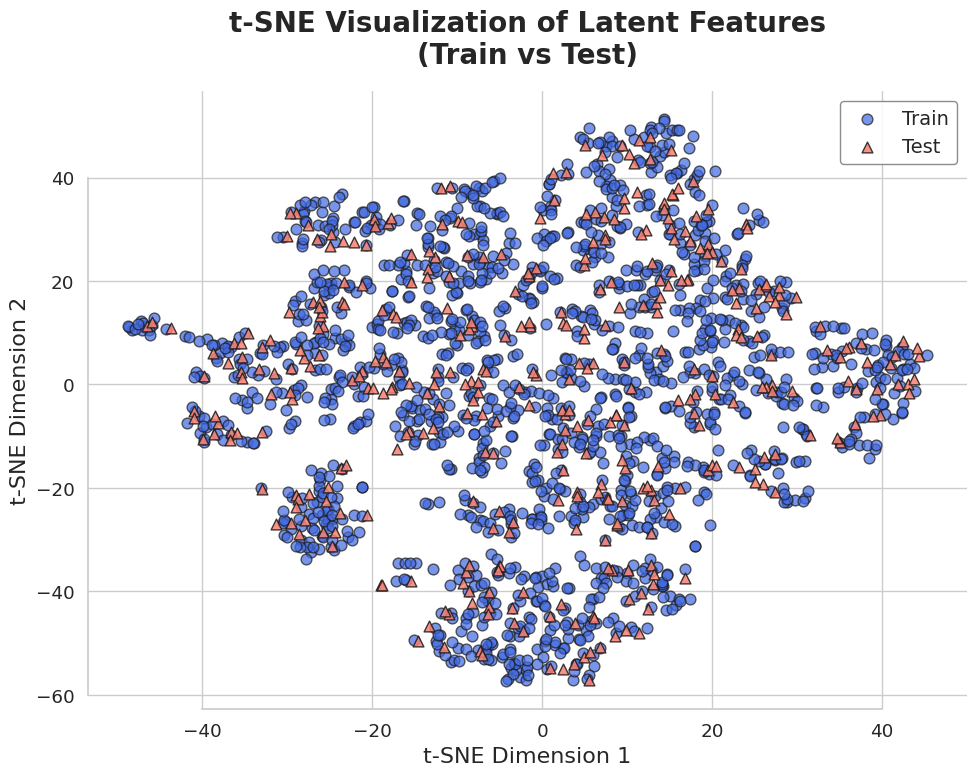

In [15]:
from plotting import plot_latent_rep

plot_latent_rep(latent_train, latent_test)

# Clustering

In [16]:
vae_surv = VAESurv(**config)

df_all = pd.concat([df_final_train,df_final_test])
y_all = np.concatenate([y_train,y_test])

# Convert X_all to a torch tensor (if needed)
X_all = torch.tensor(df_all.values, dtype=torch.float32)

# Train the VAE_Surv model on the full dataset
vae_surv.fit(X_all, y_all)

VAE pretraining: 100%|███████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:39<00:00,  5.06it/s]
Training: 0it [00:00, ?it/s]
Post training: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.38it/s]


In [17]:
from latent_clustering import kmeans_clustering

In [18]:
latent_features = vae_surv.transform(X_all, return_all=True)['zrep']
if isinstance(latent_features, torch.Tensor):
    latent_features = latent_features.cpu().numpy()

Average Silhouette Score for k = 8: 0.14


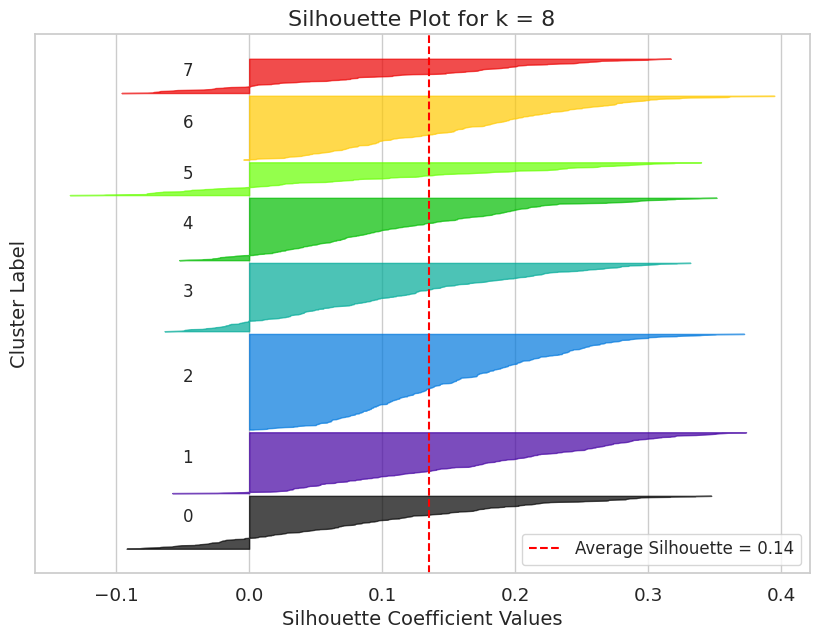

In [19]:
best_k = 8
cluster_labels = kmeans_clustering(latent_features, best_k)

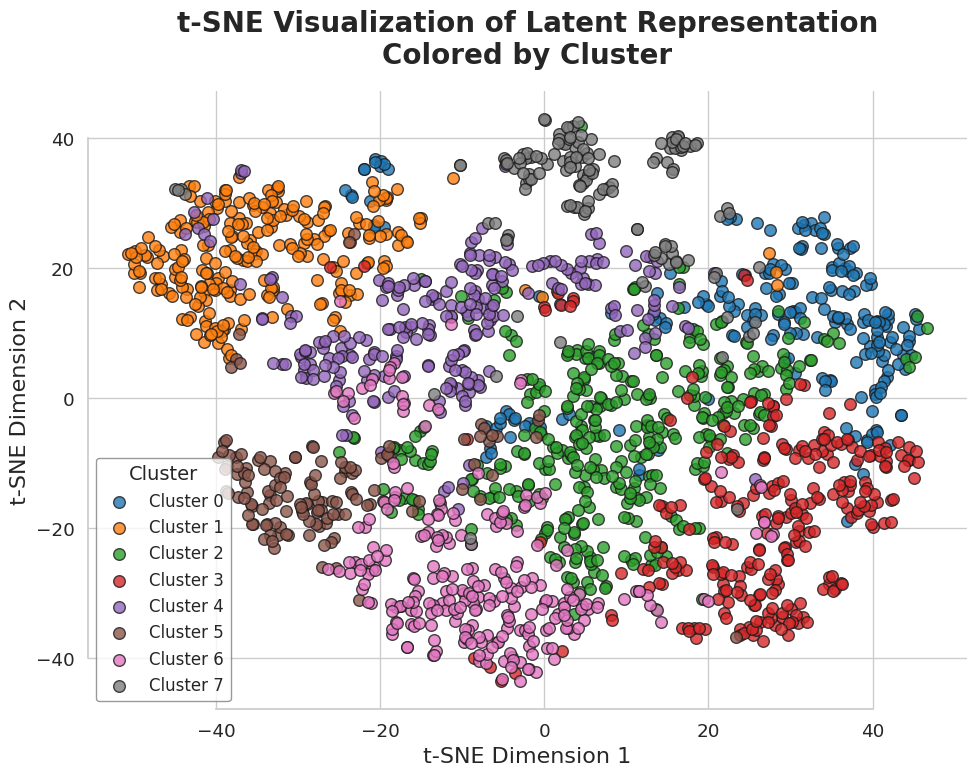

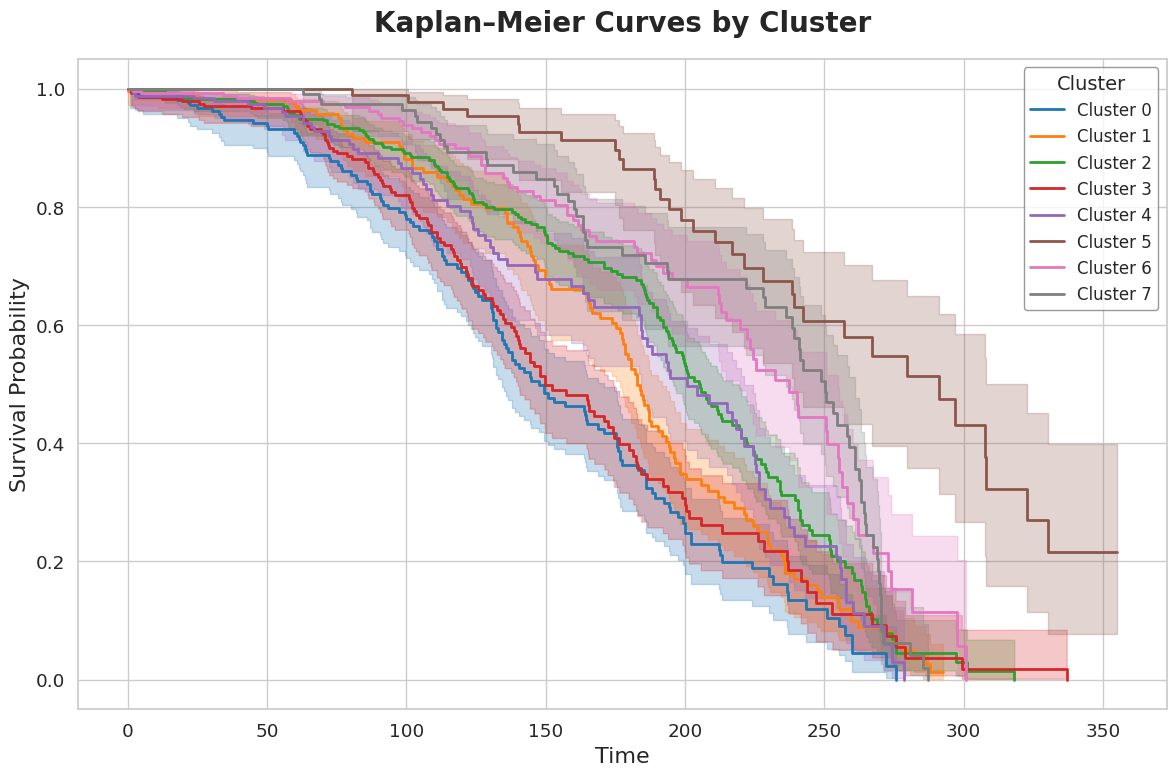

In [20]:
from plotting import plot_tsne_and_survival
plot_tsne_and_survival(latent_features, cluster_labels, y_all) 